#####  EELS Mn L3/L2 White Line Ratio

The Mn white-line ratio is calculated using Python library - Hyperspy [1]. Here we use Pearson method to extract Mn EELS white line intensities [2-3].

Procedures:

1. load dual EELS data, and align core loss edges based on corresponding zero loss peaks.

2. Denoise core loss EELS data by using principal component analysis (PCA) method.

3. The continuum of the experimental edge region is approximated by a sum of two step functions in the case of 3d metals. For the Mn-L edge, those functions are separated by the energy difference between Mn-L3 and Mn-L2.

   (1) Remove background by using "PowerLaw" function. 
   (2) Remove the effect of plural scattering by using "Fourier Ratio Deconvolution". 
   (3) A horizontal line is fitted to the spectrum in an interval beyond L2 which is a few tens of eV wide. 
   (4) After extrapolating this line into the threshold region two steps are inserted, both at the white lines center.The peak position can be measured in DigitalMicrograph (see the instructions in the folder "MeasurePeakPosition"). 
   (5) The step heights ratio of L3 and L2 is set to 2:1, which reflects the multiplicity of the initial 2p spin-orbit split states. 
   (6) By subtracting the continuum of the experimental edges, the white line intensities are obtained by integration of the peaks. According to the experimental data, the upper and lower L3 and L2 limits are selected as center +/-5.0 eV and +/-4.0 eV, respectively. 
   (7) The white line ratio is calculated: wlr = I(L3)/I(L2).
   

[1] https://hyperspy.org/.

[2] T. Riedl, et al., "Extraction of EELS white-line Intensities of Manganese Compounds: Methods, Accuracy, and Valence sensitivity", Ultramicroscopy. 106 (2006) 284-291. 

[3] D. H. Pearson., "White Lines and d-electron Occupancies for the 3d and 4d Transition Metals". Physical Review B. 47 (1993) 8471-8478.
   

In [1]:
# Load python libraries

%matplotlib notebook
import hyperspy.api as hs
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	0.0754
std:	0.152

min:	-0.3
Q1:	-0.1
median:	0.1
Q3:	0.2
max:	0.4


<IPython.core.display.Javascript object>


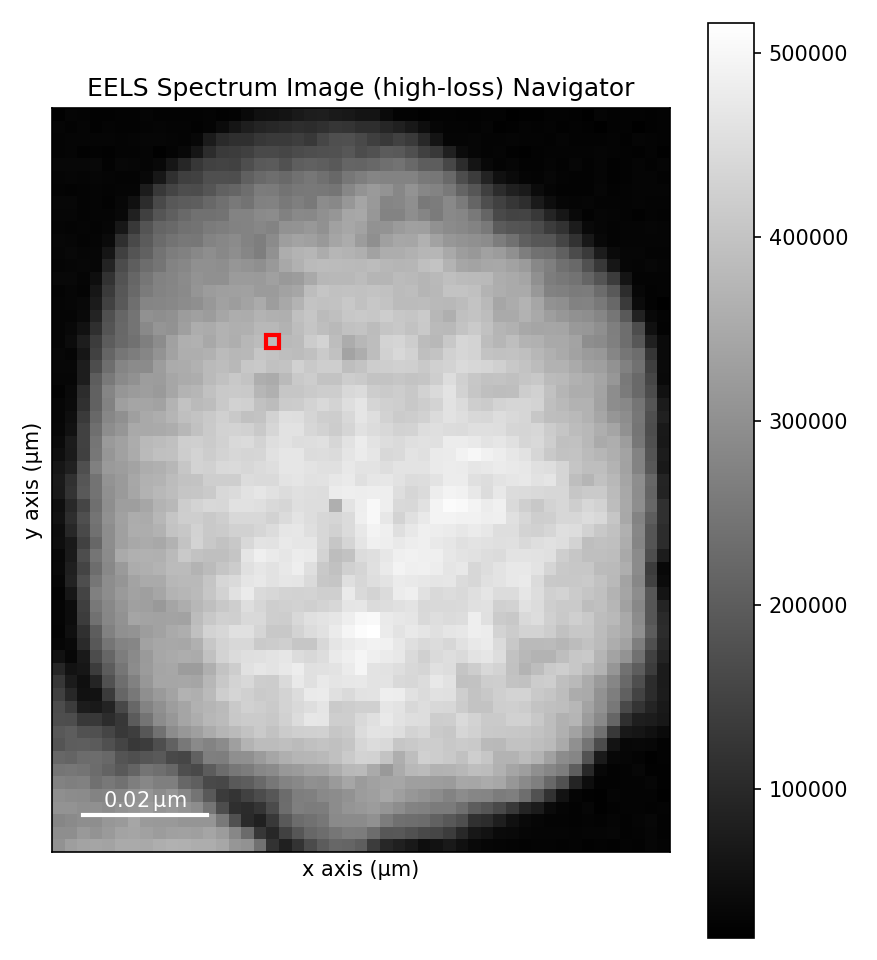

<IPython.core.display.Javascript object>


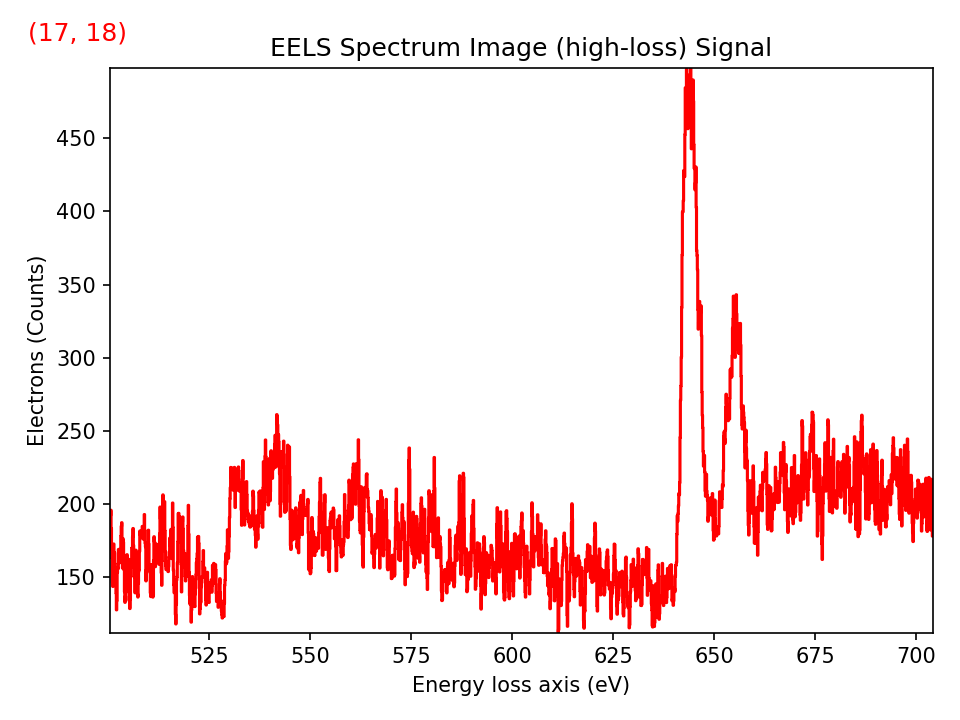

In [2]:
# Load dual EELS data, and align core loss peak based on zero loss peak

zl=hs.load('Full discharge_ll.dm4')
cl=hs.load('Full discharge_cl.dm4')

zl.align_zero_loss_peak(subpixel=True, also_align=[cl],signal_range=(-10.0,10.0))
cl.plot()

In [3]:
# Remove negative EELS signals, if any

zl.data[zl.data < 0] = 0
cl.data[cl.data < 0] = 0

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


<IPython.core.display.Javascript object>


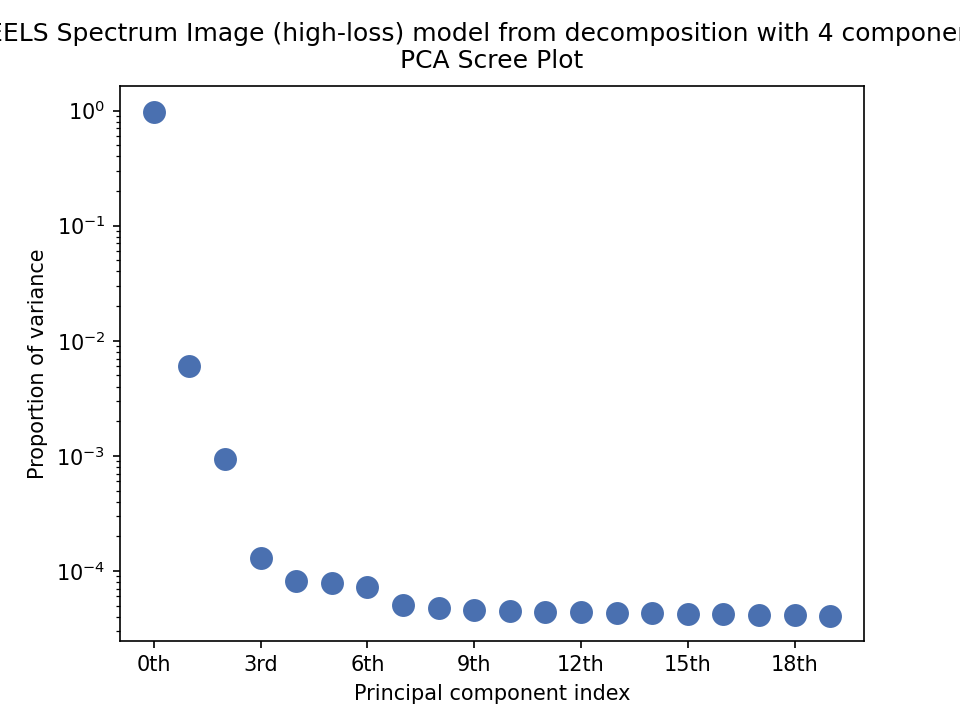

<IPython.core.display.Javascript object>


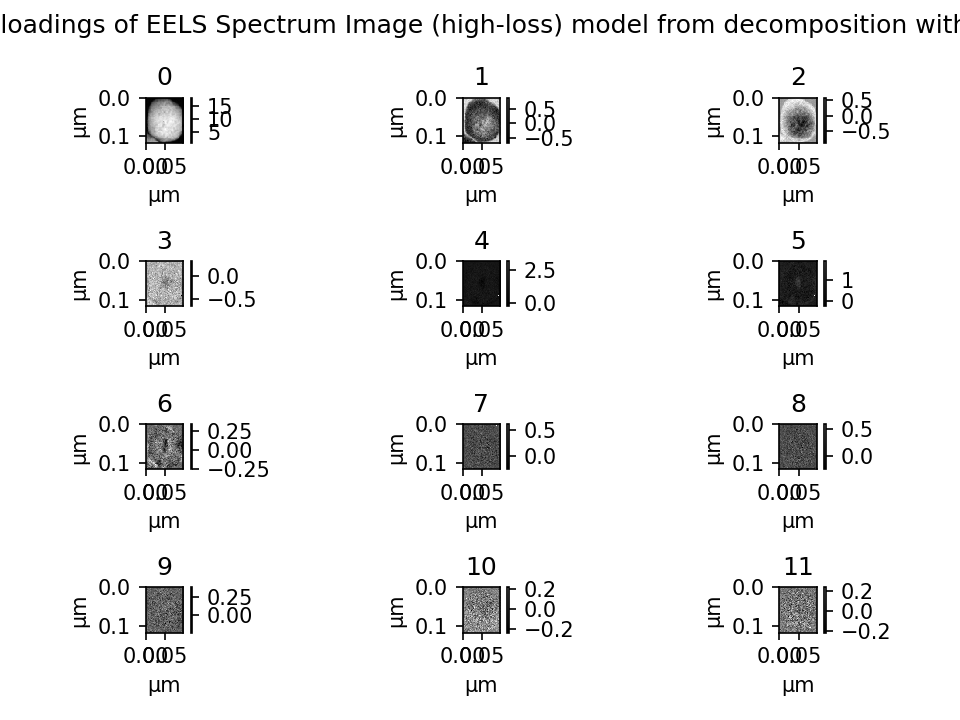

<IPython.core.display.Javascript object>


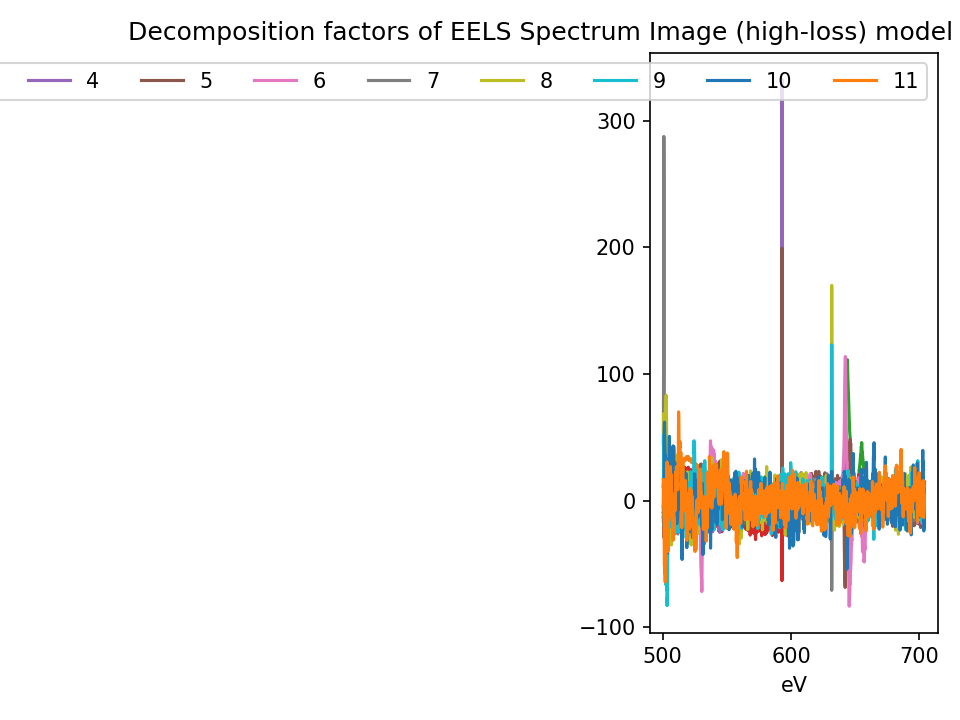

<IPython.core.display.Javascript object>


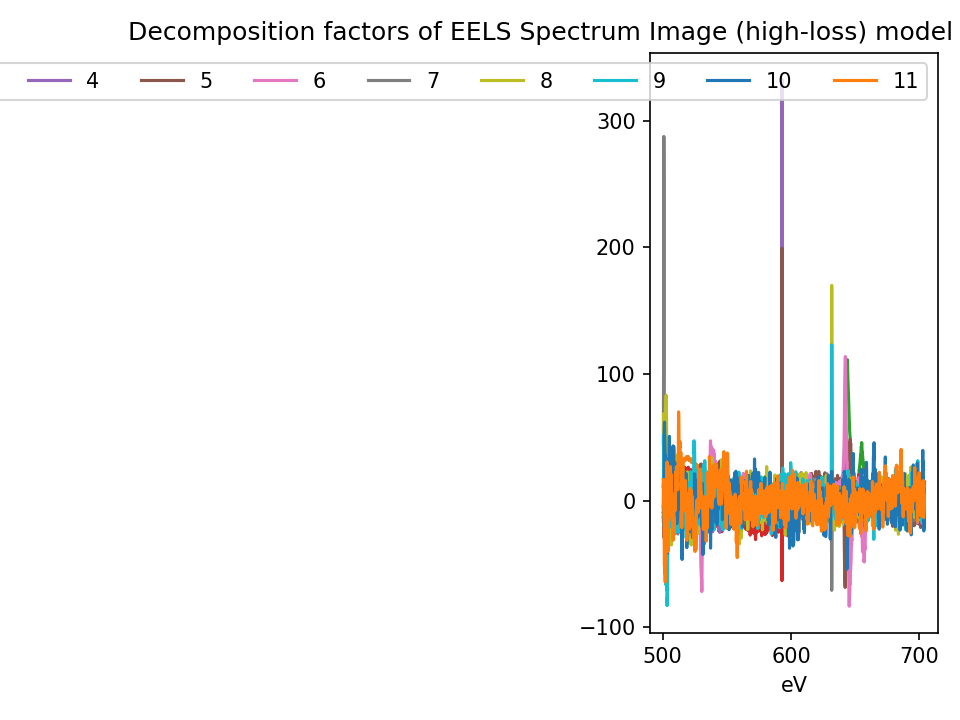

In [4]:
# Core loss EELS data denoise by using principal component analysis (PCA) method

cl.decomposition(normalize_poissonian_noise=True)
cldenoise=cl.get_decomposition_model(4)

cldenoise.plot_explained_variance_ratio(n=20)
cldenoise.plot_decomposition_loadings(12)
cldenoise.plot_decomposition_factors(12)

<IPython.core.display.Javascript object>


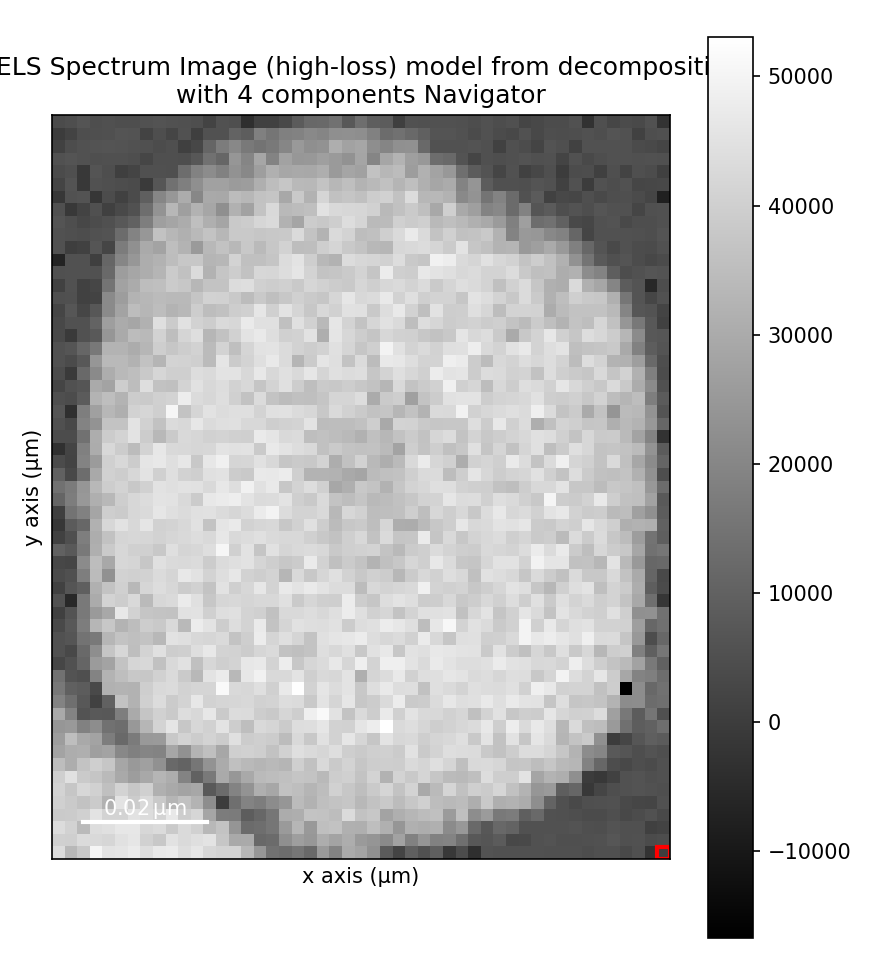

<IPython.core.display.Javascript object>


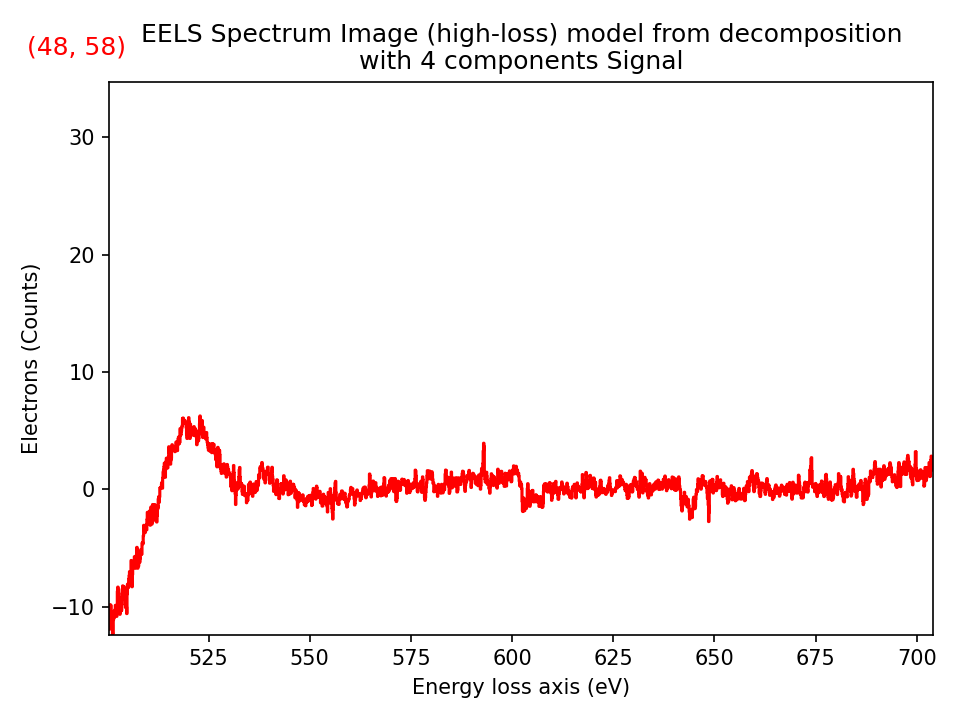

  0%|          | 0/2891 [00:00<?, ?it/s]

In [5]:
# Remove background by using "PowerLaw" function. 
# 1. Unselect "Fast" mode, select "zero fill".
# 2. Select the pre-edge window as [600., 630.] eV. The selection of pre-edge window is done by manually selecting the window in the EELS spectrum. 

cldenoise.remove_background()

<IPython.core.display.Javascript object>


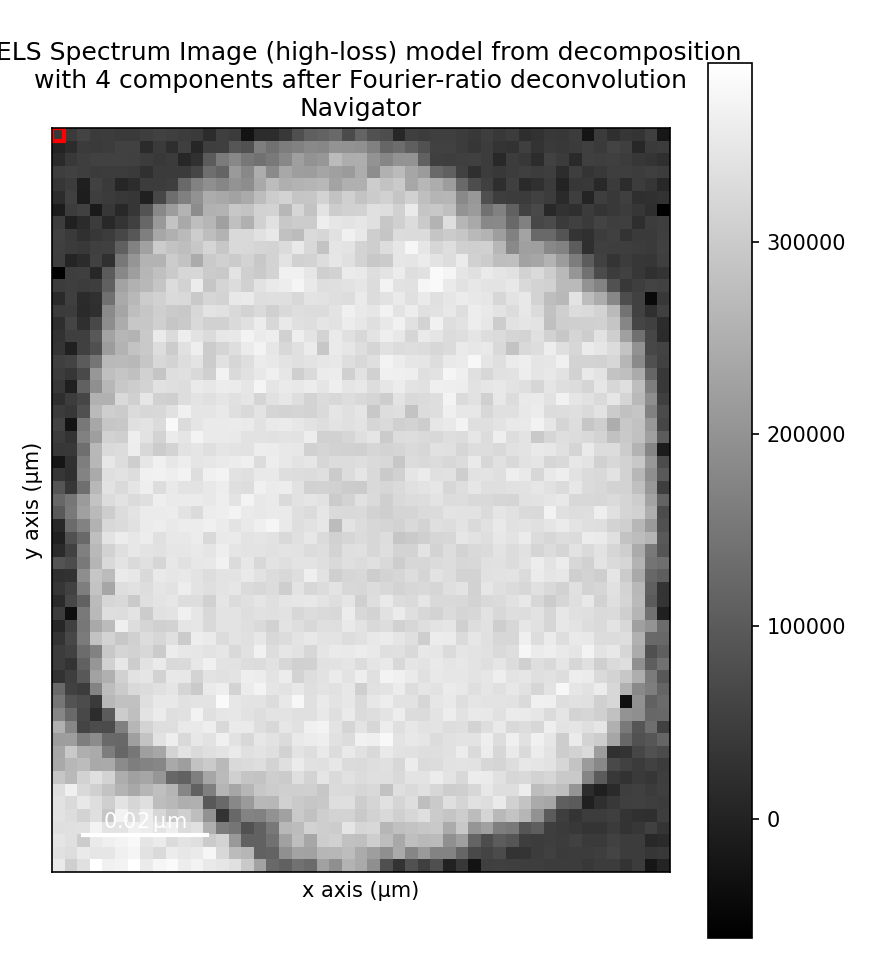

<IPython.core.display.Javascript object>


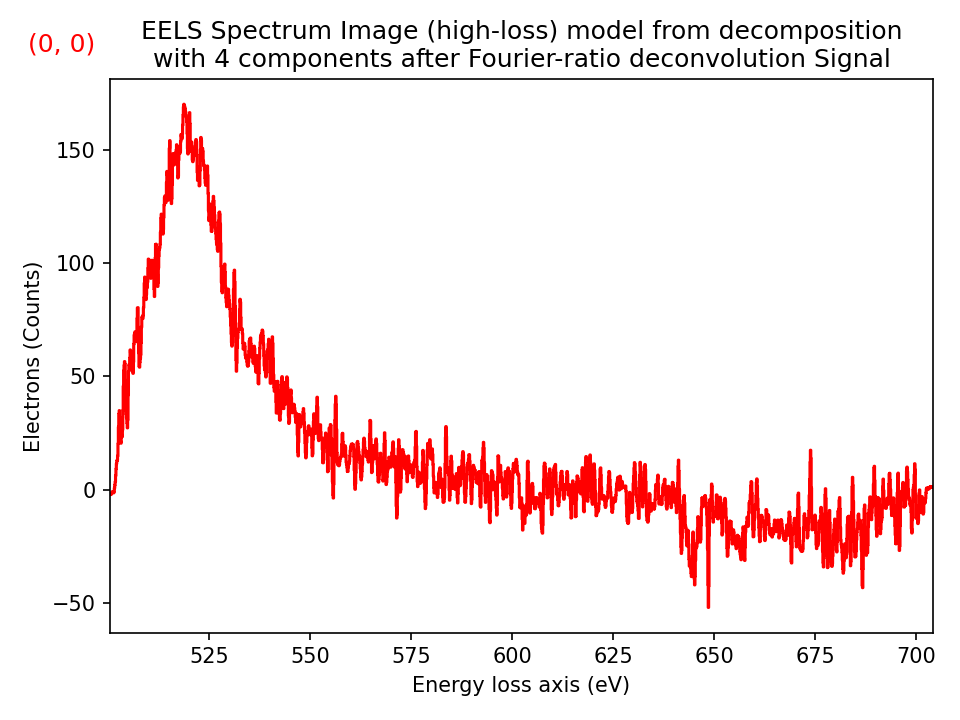

In [6]:
# Remove the effect of plural scattering by using "Fourier Ratio Deconvolution" function

cldeconv=cldenoise.fourier_ratio_deconvolution(zl,extrapolate_coreloss=False, extrapolate_lowloss=False)
cldeconv.plot()

In [7]:
# Type in the Mn L3 and L2 peak positions. The peak position can be measured in DigitalMicrograph (see the instructions 
# in the folder "MeasurePeakPosition"). The peak positions of example datasets are given as follows:
# Typical values for pristine nanoparticles: l3p=645.6, l2p=656.4;
# Typical values for intermediate state nanoparticles: l3p=645.6, l2p=656.1;
# Typical values for fully discharged nanoparticles: l3p=644.8, l2p=655.5;

l3p=644.8
l2p=655.5
win3=10.0
win2=8.0
backg=np.array(cldeconv.isig[661.0:667.0].integrate1D(axis="Energy loss"))/60
mnl3 = cldeconv.isig[(l3p-win3/2):(l3p+win3/2)].integrate1D(axis="Energy loss")-backg*(2/3)*((win3/2)/0.1)
mnl2 = cldeconv.isig[(l2p-win2/2):(l2p+win2/2)].integrate1D(axis="Energy loss")-backg*(2/3)*((win2/2)/0.1)-backg*((win2/2)/0.1)
#backga=np.average(backg)
#backga

In [8]:
# Calculate white line ratio.

r=np.divide(np.array(mnl3),np.array(mnl2))
ratio=pd.DataFrame(r)
# ratio.to_csv("20190120-pristine_PCA4_20210805.csv")

In [11]:
# for RowNumber and ColumnNumber, fill in the number of rows and colunmns in the eels data matrix.

RowNumber=59
ColumnNumber=49

ratio2=[]
for i in range (RowNumber):
    tmp=[]
    for j in range (ColumnNumber):
        if r[i][j]>=6:
            tmp.append(0)
        elif r[i][j]<=0:
            tmp.append(0)
        else:
            tmp.append(r[i][j])
    ratio2.append(tmp)

In [13]:
ratio2f=pd.DataFrame(ratio2)
ratio2f.to_csv("Full discharge.csv")